# Comparison with EventDisplay

**Purpose of this notebook:**

Compare IRF and Sensitivity as computed by pyirf and EventDisplay on the same DL2 results

**Notes:**

The following results correspond to:

- Paranal site
- Zd 20 deg, Az 180 deg
- 50 h observation time

**Resources:**

_EventDisplay_ DL2 data, https://forge.in2p3.fr/projects/cta_analysis-and-simulations/wiki/Eventdisplay_Prod3b_DL2_Lists


Download and unpack the data using 

```bash
$ curl -fL -o data.zip https://nextcloud.e5.physik.tu-dortmund.de/index.php/s/Cstsf8MWZjnz92L/download
$ unzip data.zip
$ mv eventdisplay_dl2 data
```

## Table of contents

* [Optimized cuts](#Optimized-cuts)
    - [Direction cut](#Direction-cut)
* [Differential sensitivity from cuts optimization](#Differential-sensitivity-from-cuts-optimization)
* [IRFs](#IRFs)
    - [Effective area](#Effective-area)
    - [Point Spread Function](#Point-Spread-Function)
        + [Angular resolution](#Angular-resolution)
    - [Energy dispersion](#Energy-dispersion)
        + [Energy resolution](#Energy-resolution)
    - [Background rate](#Background-rate)

## Imports

In [1]:
import os

import numpy as np
import uproot
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.table import QTable

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (9, 6)

## Input data

### _EventDisplay_

The input data provided by _EventDisplay_ is stored in _ROOT_ format, so _uproot_ is used to transform it into _numpy_ objects. 

In [3]:
# Path of EventDisplay IRF data in the user's local setup
# Please, empty the indir_EventDisplay variable before pushing to the repo
indir = "../../data/"
irf_file_event_display = "DESY.d20180113.V3.ID0_180degNIM2LST4MST4SST4SCMST4.prod3b-paranal20degs05b-NN.S.3HB9-FD.180000s.root"

irf_eventdisplay = uproot.open(os.path.join(indir, irf_file_event_display))

## _pyirf_

The following is the current IRF + sensititivy output FITS format provided by this software.

Run `python examples/calculate_eventdisplay_irfs.py` after downloading the data

In [5]:
Pyirf_file = ['../../pyirf_eventdisplay0.fits.gz','../../pyirf_eventdisplay1.fits.gz']

## Optimized cuts
[back to top](#Table-of-contents)

### Direction cut
[back to top](#Table-of-contents)

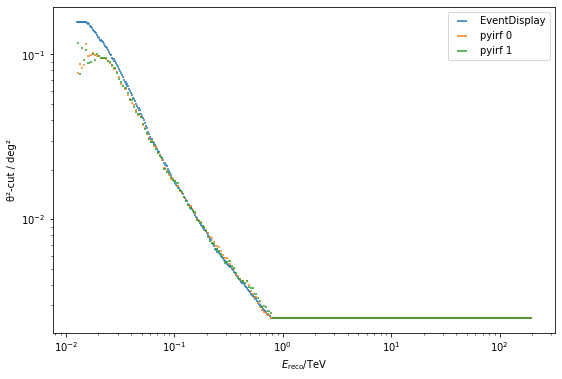

In [9]:
from astropy.table import QTable

theta_cut_ed = irf_eventdisplay['ThetaCut;1']
plt.errorbar(
    10**theta_cut_ed.edges[:-1],
    theta_cut_ed.values**2,
    xerr=np.diff(10**theta_cut_ed.edges),
    ls='',
    label='EventDisplay',
)

for n, pyirf_file in enumerate(Pyirf_file):
    rad_max = QTable.read(pyirf_file, hdu='RAD_MAX')[0]

    plt.errorbar(
        0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])[1:-1].to_value(u.TeV),
        rad_max['RAD_MAX'].T[1:-1, 0].to_value(u.deg)**2,
        xerr=0.5 * (rad_max['ENERG_HI'] - rad_max['ENERG_LO'])[1:-1].to_value(u.TeV),
        ls='',
        label='pyirf '+ repr(n) ,
    )

plt.legend()
plt.ylabel('θ²-cut / deg²')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')
plt.yscale('log')

None # to remove clutter by mpl objects

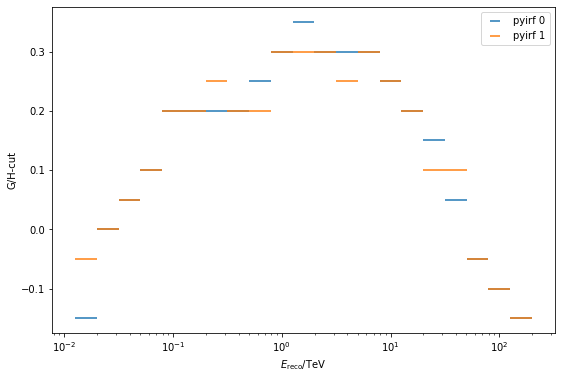

In [11]:
from astropy.table import QTable

for n, pyirf_file in enumerate(Pyirf_file):
    gh_cut = QTable.read(pyirf_file, hdu='GH_CUTS')[1:-1]


    plt.errorbar(
        0.5 * (gh_cut['low'] + gh_cut['high']).to_value(u.TeV),
        gh_cut['cut'],
        xerr=0.5 * (gh_cut['high'] - gh_cut['low']).to_value(u.TeV),
        ls='',
        label='pyirf ' + repr(n),
    )

plt.legend()
plt.ylabel('G/H-cut')
plt.xlabel(r'$E_\mathrm{reco} / \mathrm{TeV}$')
plt.xscale('log')

None # to remove clutter by mpl objects

## Differential sensitivity from cuts optimization
[back to top](#Table-of-contents)

In [13]:
# [1:-1] removes under/overflow bin
#sensitivity = QTable.read(pyirf_file, hdu='SENSITIVITY')[1:-1]
#sensitivity

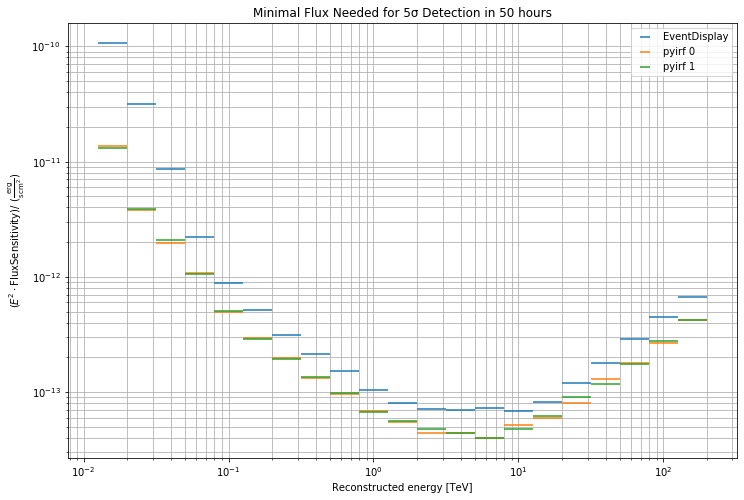

In [14]:
plt.figure(figsize=(12,8))

# Get data from event display file
h = irf_eventdisplay["DiffSens"]
bins = 10**h.edges
x = 0.5 * (bins[:-1] + bins[1:])
width = np.diff(bins)
y = h.values

plt.errorbar(
    x,
    y, 
    xerr=width/2,
    yerr=None,
    label="EventDisplay",
    ls=''
)

unit = u.Unit('erg cm-2 s-1')

for n, pyirf_file in enumerate(Pyirf_file):
    
    sensitivity = QTable.read(pyirf_file, hdu='SENSITIVITY')[1:-1]
    e = sensitivity['reco_energy_center']
    s = (e**2 * sensitivity['flux_sensitivity'])

    plt.errorbar(
        e.to_value(u.TeV),
        s.to_value(unit),
        xerr=(sensitivity['reco_energy_high'] - sensitivity['reco_energy_low']).to_value(u.TeV) / 2,
        ls='',
        label='pyirf ' + repr(n)
    )

# Style settings
plt.title('Minimal Flux Needed for 5σ Detection in 50 hours')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Reconstructed energy [TeV]")
plt.ylabel(rf"$(E^2 \cdot \mathrm{{Flux Sensitivity}}) /$ ({unit.to_string('latex')})")
plt.grid(which="both")
plt.legend()

None # to remove clutter by mpl objects

## IRFs
[back to top](#Table-of-contents)

### Effective area
[back to top](#Table-of-contents)

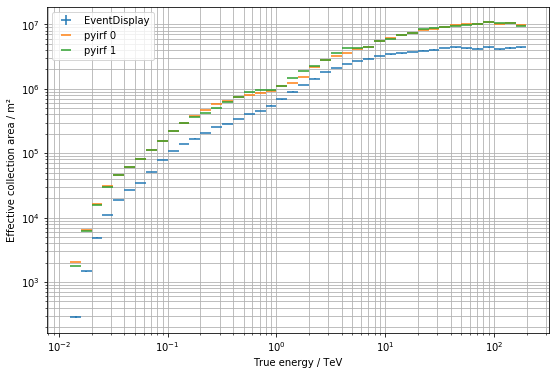

In [15]:
# Data from EventDisplay
h = irf_eventdisplay["EffectiveAreaEtrue"]

x = 0.5 * (10**h.edges[:-1] + 10**h.edges[1:])
xerr = 0.5 * np.diff(10**h.edges)
y = h.values
yerr = np.sqrt(h.variances)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="EventDisplay")

for n, pyirf_file in enumerate(Pyirf_file):
    
    area = QTable.read(pyirf_file, hdu='EFFECTIVE_AREA')[0]
    
    plt.errorbar(
        0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1],
        area['EFFAREA'].to_value(u.m**2).T[1:-1, 0],
        xerr=0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1],
        ls='',
        label='pyirf ' + repr(n),
    )
    
# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Effective collection area / m²")
plt.grid(which="both")
plt.legend()

None # to remove clutter by mpl objects

### Point Spread Function
[back to top](#Table-of-contents)

PSF 0


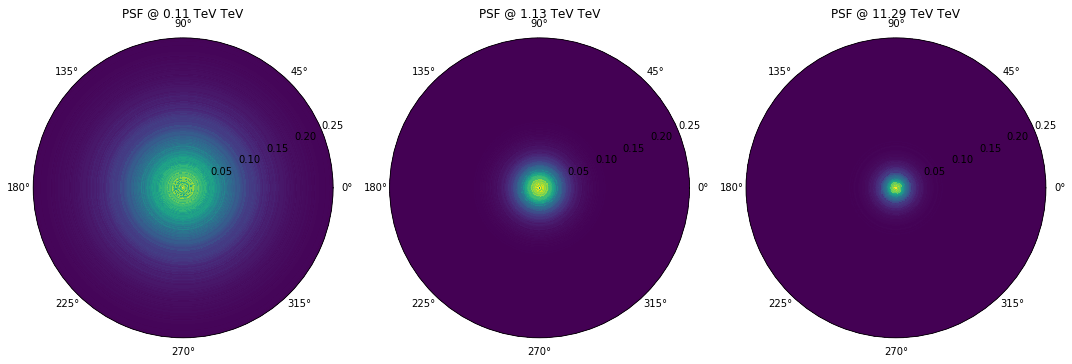

PSF 1


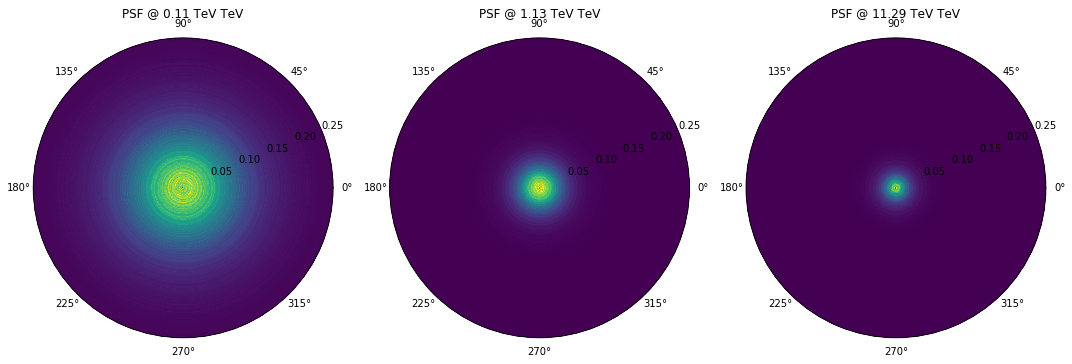

In [24]:
for n, pyirf_file in enumerate(Pyirf_file):
    
    psf_table = QTable.read(pyirf_file, hdu='PSF')[0]
    # select the only fov offset bin
    psf = psf_table['RPSF'].T[:, 0, :].to_value(1 / u.sr)

    offset_bins = np.append(psf_table['RAD_LO'], psf_table['RAD_HI'][-1])
    phi_bins = np.linspace(0, 2 * np.pi, 100)

    # Let's make a nice 2d representation of the radially symmetric PSF
    r, phi = np.meshgrid(offset_bins.to_value(u.deg), phi_bins)

    # look at a single energy bin
    # repeat values for each phi bin
    center = 0.5 * (psf_table['ENERG_LO'] + psf_table['ENERG_HI'])

    fig = plt.figure(figsize=(15, 5))  
    
    print('PSF '+ repr(n))
    
    axs = [fig.add_subplot(1, 3, i, projection='polar') for i in range(1, 4)]


    for bin_id, ax in zip([10, 20, 30], axs):
        image = np.tile(psf[bin_id], (len(phi_bins) - 1, 1))

        ax.set_title(f'PSF @ {center[bin_id]:.2f} TeV')
        ax.pcolormesh(phi, r, image)
        ax.set_ylim(0, 0.25)
        ax.set_aspect(1)
    
    fig.tight_layout()
    plt.show()

    None # to remove clutter by mpl objects

In [26]:
"""# Profile
center = 0.5 * (offset_bins[1:] + offset_bins[:-1])
xerr = 0.5 * (offset_bins[1:] - offset_bins[:-1])

for bin_id in [10, 20, 30]:
    plt.errorbar(
        center.to_value(u.deg),
        psf[bin_id],
        xerr=xerr.to_value(u.deg),
        ls='',
        label=f'Energy Bin {bin_id}'
    )
    
#plt.yscale('log')
plt.legend()
plt.xlim(0, 0.25)
plt.ylabel('PSF PDF / sr⁻¹')
plt.xlabel('Distance from True Source / deg')

None # to remove clutter by mpl objects"""

"# Profile\ncenter = 0.5 * (offset_bins[1:] + offset_bins[:-1])\nxerr = 0.5 * (offset_bins[1:] - offset_bins[:-1])\n\nfor bin_id in [10, 20, 30]:\n    plt.errorbar(\n        center.to_value(u.deg),\n        psf[bin_id],\n        xerr=xerr.to_value(u.deg),\n        ls='',\n        label=f'Energy Bin {bin_id}'\n    )\n    \n#plt.yscale('log')\nplt.legend()\nplt.xlim(0, 0.25)\nplt.ylabel('PSF PDF / sr⁻¹')\nplt.xlabel('Distance from True Source / deg')\n\nNone # to remove clutter by mpl objects"

#### Angular resolution
[back to top](#Table-of-contents)

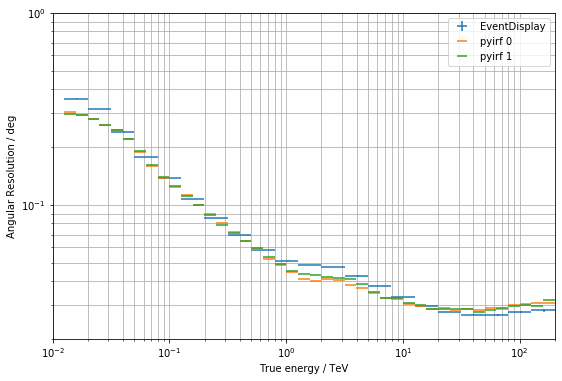

In [28]:
# Data from EventDisplay
h = irf_eventdisplay["AngRes"]
x = 0.5 * (10**h.edges[:-1] + 10**h.edges[1:])
xerr = 0.5 * np.diff(10**h.edges)
y = h.values
yerr = np.sqrt(h.variances)
plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="EventDisplay")

# pyirf
for n, pyirf_file in enumerate(Pyirf_file):
    ang_res = QTable.read(pyirf_file, hdu='ANGULAR_RESOLUTION')[1:-1]

    plt.errorbar(
        0.5 * (ang_res['true_energy_low'] + ang_res['true_energy_high']).to_value(u.TeV),
        ang_res['angular_resolution'].to_value(u.deg),
        xerr=0.5 * (ang_res['true_energy_high'] - ang_res['true_energy_low']).to_value(u.TeV),
        ls='',
        label='pyirf '+ repr(n)
    )

# Style settings
plt.xlim(1.e-2, 2.e2)
plt.ylim(2.e-2, 1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Angular Resolution / deg")
plt.grid(which="both")
plt.legend(loc="best")

None # to remove clutter by mpl objects

### Energy dispersion
[back to top](#Table-of-contents)

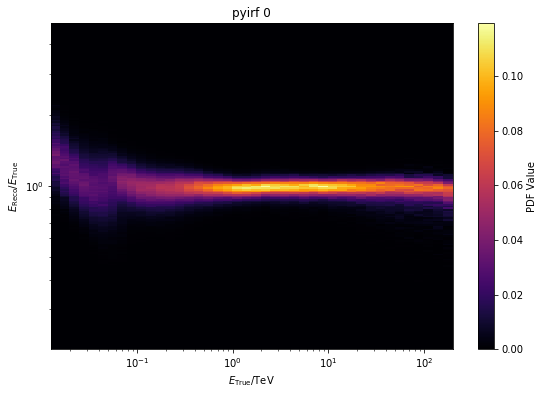

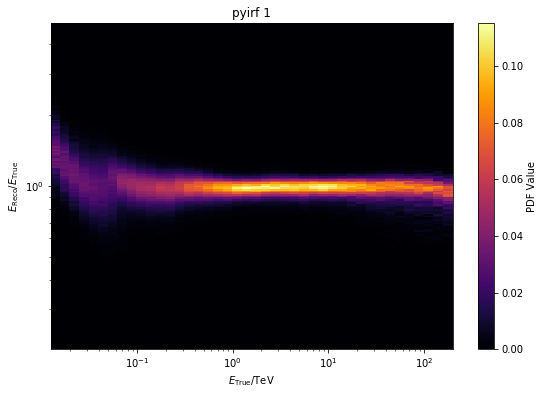

In [31]:
for n, pyirf_file in enumerate(Pyirf_file):
    
    edisp = QTable.read(pyirf_file, hdu='ENERGY_DISPERSION')[0]

    e_bins = edisp['ENERG_LO'][1:]
    migra_bins = edisp['MIGRA_LO'][1:]

    plt.title('pyirf ' + repr(n))
    plt.pcolormesh(e_bins.to_value(u.TeV), migra_bins, edisp['MATRIX'].T[1:-1, 1:-1, 0].T, cmap='inferno')

    plt.xscale('log')
    plt.yscale('log')
    plt.colorbar(label='PDF Value')

    plt.xlabel(r'$E_\mathrm{True} / \mathrm{TeV}$')
    plt.ylabel(r'$E_\mathrm{Reco} / E_\mathrm{True}$')
    plt.show()

    None # to remove clutter by mpl objects

#### Energy resolution
[back to top](#Table-of-contents)

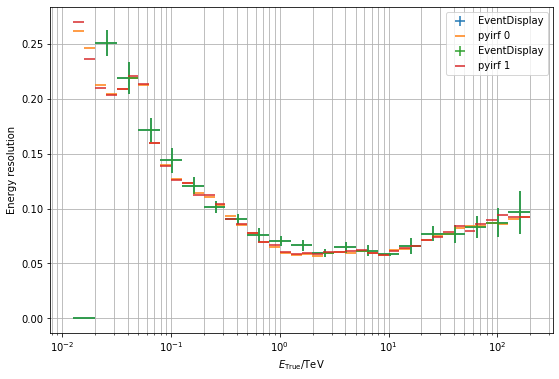

In [32]:
# Data from EventDisplay
h = irf_eventdisplay["ERes"]
x = 0.5 * (10**h.edges[:-1] + 10**h.edges[1:])
xerr = np.diff(10**h.edges) / 2
y = h.values
yerr = np.sqrt(h.variances)

for n, pyirf_file in enumerate(Pyirf_file):
    # Data from pyirf
    bias_resolution = QTable.read(pyirf_file, hdu='ENERGY_BIAS_RESOLUTION')[1:-1]

    # Plot function
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="EventDisplay")
    plt.errorbar(
        0.5 * (bias_resolution['true_energy_low'] + bias_resolution['true_energy_high']).to_value(u.TeV),
        bias_resolution['resolution'],
        xerr=0.5 * (bias_resolution['true_energy_high'] - bias_resolution['true_energy_low']).to_value(u.TeV),
        ls='',
        label='pyirf '+ repr(n)
    )

plt.xscale('log')

# Style settings
plt.xlabel(r"$E_\mathrm{True} / \mathrm{TeV}$")
plt.ylabel("Energy resolution")
plt.grid(which="both")
plt.legend(loc="best")

None # to remove clutter by mpl objects

### Background rate
[back to top](#Table-of-contents)

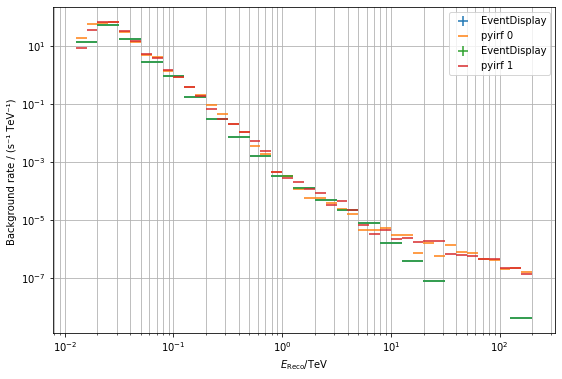

In [33]:
from pyirf.utils import cone_solid_angle

# Data from EventDisplay
h = irf_eventdisplay["BGRate"]
x = 0.5 * (10**h.edges[:-1] + 10**h.edges[1:])
width = np.diff(10**h.edges)
xerr = width / 2
y = h.values / width
yerr = np.sqrt(h.variances)

# pyirf data
for n, pyirf_file in enumerate(Pyirf_file):
    bg_rate = QTable.read(pyirf_file, hdu='BACKGROUND')[0]

    reco_bins = np.append(bg_rate['ENERG_LO'], bg_rate['ENERG_HI'][-1])

    # first fov bin, [0, 1] deg
    fov_bin = 0
    rate_bin = bg_rate['BKG'].T[:, fov_bin]


    # interpolate theta cut for given e reco bin
    e_center_bg = 0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI'])
    e_center_theta = 0.5 * (rad_max['ENERG_LO'] + rad_max['ENERG_HI'])
    theta_cut = np.interp(e_center_bg, e_center_theta, rad_max['RAD_MAX'].T[:, 0])

    # undo normalization
    rate_bin *= cone_solid_angle(theta_cut)


    # Plot function
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='', label="EventDisplay")

    plt.errorbar(
        0.5 * (bg_rate['ENERG_LO'] + bg_rate['ENERG_HI']).to_value(u.TeV)[1:-1],
        rate_bin.to_value(1 / (u.TeV * u.s))[1:-1],
        xerr=np.diff(reco_bins).to_value(u.TeV)[1:-1] / 2,
        ls='',
        label='pyirf ' + repr(n),
    )

# Style settings
plt.xscale("log")
plt.xlabel(r"$E_\mathrm{Reco} / \mathrm{TeV}$")
plt.ylabel("Background rate / (s⁻¹ TeV⁻¹) ")
plt.grid(which="both")
plt.legend(loc="best")
plt.yscale('log')

None # to remove clutter by mpl objects